In [30]:
import pandas as pd
import numpy as np
import os
import json
import csv
import matplotlib.pyplot as plt

# Read in Performance Data
all tests represent one full run on the "c-testsuit" with python 3.8.
some of the tests where run on a MacBook Pro M1, some other where run on a Lenovo Thinkpad Intel Core i7 1165G7. 
all results are averaged over 3-6 runs of the same test.

In [72]:
all_dirs = [f for f in os.listdir("../data/") if f!=".DS_Store"]

data = list()
info_header = ['COMPILER_1', 'COMPILER_2', 'INT_BOUNDS', 'FLOAT_BOUNDS', 'ARRAY_BOUNDS', 'MUTATION_STRATEGY', 'NUM_VALID_MUTANTS', 'NUM_TOTAL_MUTANTS', 'RUN_TIMEOUT', 'COMPILE_TIMEOUT', 'NUM_THREADS']
summary_header = ["num_seeds", "total_attempts", "total_valid_attempts", "total_elapsed_s", "detected_diffs", "mutated_valid", "mutated_compile_error", "mutated_compile_timeout", "mutated_invalid", "mutated_run_timeout"]
for d in all_dirs:
    r_name = "-".join(d.split("-")[:-2])
    if r_name == "evaluate_array_awareness":
        r_name = "-".join(d.split("-")[:-1])
    d_info = list()
    d_sum = list()
    # read in info
    with open(os.path.join("..", "data", d, "run_info.csv"), 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)
        data_list = [row for row in csv_reader]
        d_info = data_list[0]
        if len(d_info) == 10:
            d_info.insert(4, "int32+")

    # read in summary
    order = ["valid", "compile error", "compile timeout", "invalid", "run timeout"]
    with open(os.path.join("..", "data", d, "run_summary.csv"), "r") as f:
        header = f.readline()
        summary = f.readline()
        first_five_list = [float(x) for x in (summary.split("{")[0]).split(",") if x]
        summary_str = "{" + summary.split("{")[1]
        summary_dict = json.loads(summary_str.replace("'", '"'))
        summary_list = [summary_dict.get(key) if key in summary_dict else 0 for key in order]
        d_sum = first_five_list + summary_list
    data.append([r_name] + d_info + d_sum)
df = pd.DataFrame(data, columns=["run_name"] + info_header + summary_header)
df

['compare-runtime-int8' 'evaluate_array_awareness-random'
 'evaluate_array_awareness-array_aware' 'compare-runtime'
 'compare-runtime-large-int32' 'compare-runtime-large-int8']


# Performance Comparison int8 values vs. int32 values
In this first performance test, we want to find out:
1) is there a speed difference when sampling from int8 vs. int32 values for constants?
2) how does the validity of the mutations change when using smaller sampling ranges for the constants?

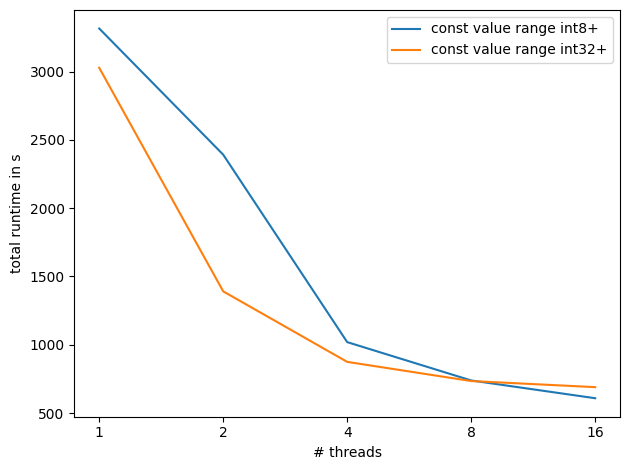

In [67]:
# Assuming your DataFrame is named 'df'
# Selecting the rows with run_name "compare-runtime-int8"
int8_rows = df[df['run_name'] == 'compare-runtime-int8']
int32_rows = df[df['run_name'] == 'compare-runtime']

# Calculating the average of NUM_THREADS for each total_elapsed_s in int8_rows
int8_avg_time = int8_rows.groupby('NUM_THREADS')['total_elapsed_s'].mean().sort_values(ascending=False)
int32_avg_time = runtime_rows.groupby('NUM_THREADS')['total_elapsed_s'].mean().sort_values(ascending=False)

# Plotting the lines
plt.plot(int8_avg_time.index, int8_avg_time.values, label='const value range int8+')
plt.plot(int32_avg_time.index, int32_avg_time.values, label='const value range int32+')

# Adding labels and legend
#plt.title("speed difference sampling int8+ vs. int32+ consts")
plt.xlabel('# threads')
plt.ylabel('total runtime in s')
plt.legend()
plt.axis('auto')
plt.tight_layout()


plt.savefig('speed_comparison_sample_range.pdf')

# Display the plot
plt.show()

/var/folders/x1/c0ypb7g51_g2vps0fz3xx_mm0000gn/T/ipykernel_78362/2101456034.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  int8_mutation_counts = pd.Series([np.nan]).append(int8_mutation_counts)
/var/folders/x1/c0ypb7g51_g2vps0fz3xx_mm0000gn/T/ipykernel_78362/2101456034.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  runtime_mutation_counts = pd.Series([np.nan]).append(runtime_mutation_counts)


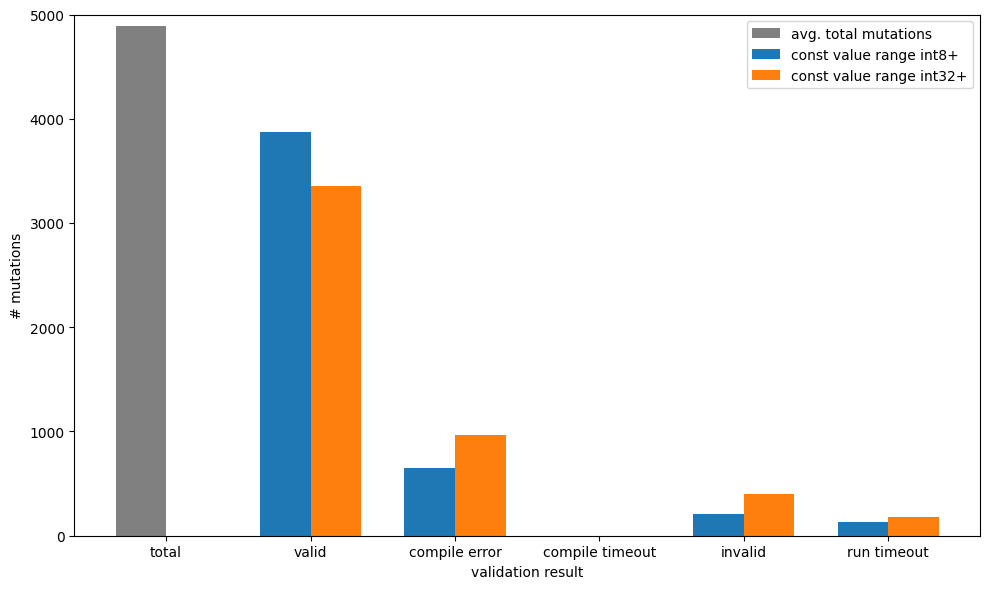

In [85]:

# Assuming your DataFrame is named 'df'
# Selecting the rows with run_name "compare-runtime-int8" and "compare-runtime"
int8_rows = df[df['run_name'] == 'compare-runtime-int8']
runtime_rows = df[df['run_name'] == 'compare-runtime']

# Calculating the counts of mutation types for "compare-runtime-int8"
int8_mutation_counts = int8_rows[['mutated_valid', 'mutated_compile_error', 'mutated_compile_timeout', 'mutated_invalid', 'mutated_run_timeout']].mean()
int8_mutation_counts = pd.Series([np.nan]).append(int8_mutation_counts)

# Calculating the counts of mutation types for "compare-runtime"
runtime_mutation_counts = runtime_rows[['mutated_valid', 'mutated_compile_error', 'mutated_compile_timeout', 'mutated_invalid', 'mutated_run_timeout']].mean()
runtime_mutation_counts = pd.Series([np.nan]).append(runtime_mutation_counts)

int8_avg_total_mutations = int8_rows['total_attempts'].mean()
runtime_avg_total_mutations = runtime_rows['total_attempts'].mean()
avg_total_mutations = pd.Series([(int8_avg_total_mutations + runtime_avg_total_mutations) / 2, 0, 0, 0, 0, 0])


# Getting the mutation types as columns
mutation_types = int8_mutation_counts.index
mutation_types = ["total"] + [" ".join(x.split("_")[1:]) for x in mutation_types[1:]]

# Plotting the bar plot
bar_width = 0.35
index = range(len(mutation_types))
plt.figure(figsize=(10, 6))

plt.bar(index, avg_total_mutations, bar_width, color="grey", label='avg. total mutations')
plt.bar(index, int8_mutation_counts, bar_width, label='const value range int8+')
plt.bar([i + bar_width for i in index], runtime_mutation_counts, bar_width, label='const value range int32+')

# Adding labels and ticks
# plt.title("mutation validity sampling int8+ vs. int32+ consts")
plt.xlabel('validation result')
plt.ylabel('# mutations')
plt.xticks([i + bar_width/2 for i in index], mutation_types)

# Adding legend
plt.legend()
plt.ylim(0, 5000)
plt.tight_layout()

plt.savefig('validation_comparison_sample_range.pdf')

# Display the plot
plt.show()


# Finding optimal number of worker Threads
Before running the Fuzzer on the whole testuite to find big differences, we wanted to find the optimal thread count.
The performance results of the sample range comparison indicated that the optimal count is between 8 and 16.
Since those results were generated on merely 32 mutants per seed file (each thread had only 2-4 mutations), we ran the same comparison again, but generated 128 mutants per seed file.
We tried to reduce the threading overhead by letting each thread process more mutations.

NUM_THREADS
8     2845.130000
16    2713.713333
Name: total_elapsed_s, dtype: float64
NUM_THREADS
8     2868.520
16    2730.355
Name: total_elapsed_s, dtype: float64


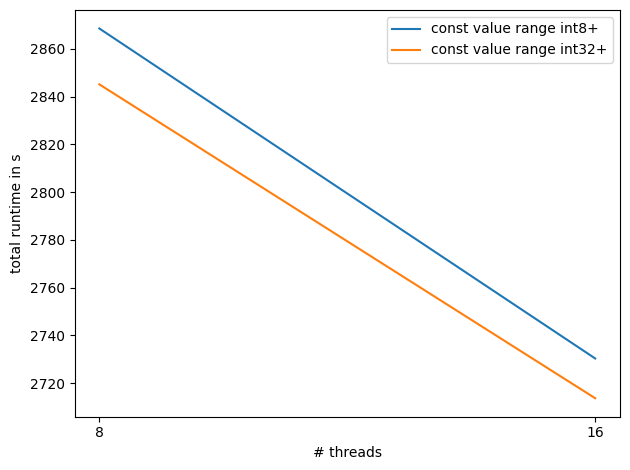

In [69]:
# Assuming your DataFrame is named 'df'
# Selecting the rows with run_name "compare-runtime-int8"
int8_large_rows = df[df['run_name'] == 'compare-runtime-large-int8']
int32_large_rows = df[df['run_name'] == 'compare-runtime-large-int32']

# Calculating the average of NUM_THREADS for each total_elapsed_s in int8_rows
int8_large_time = int8_large_rows.groupby('NUM_THREADS')['total_elapsed_s'].mean().sort_values(ascending=False)
int32_large_time = int32_large_rows.groupby('NUM_THREADS')['total_elapsed_s'].mean().sort_values(ascending=False)

print(int32_large_time)
print(int8_large_time)

# Plotting the lines
plt.plot(int8_large_time.index, int8_large_time.values, label='const value range int8+')
plt.plot(int32_large_time.index, int32_large_time.values, label='const value range int32+')

# Adding labels and legend
#plt.title("speed difference sampling int8+ vs. int32+ consts")
plt.xlabel('# threads')
plt.ylabel('total runtime in s')
plt.legend()
plt.axis('auto')
plt.tight_layout()


plt.savefig('speed_comparison_large_sample_range.pdf')

# Display the plot
plt.show()

# Sampling Strategy Comparison random vs. array-aware
In this test we compared the random sampling strategy against the array-aware sampling strategy.

average time random sampling: 675.68
average time array-aware sampling: 706.5033333333334


/var/folders/x1/c0ypb7g51_g2vps0fz3xx_mm0000gn/T/ipykernel_78362/3155400592.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_avg_counts = pd.Series([np.nan]).append(random_avg_counts)
/var/folders/x1/c0ypb7g51_g2vps0fz3xx_mm0000gn/T/ipykernel_78362/3155400592.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aware_avg_counts = pd.Series([np.nan]).append(aware_avg_counts)


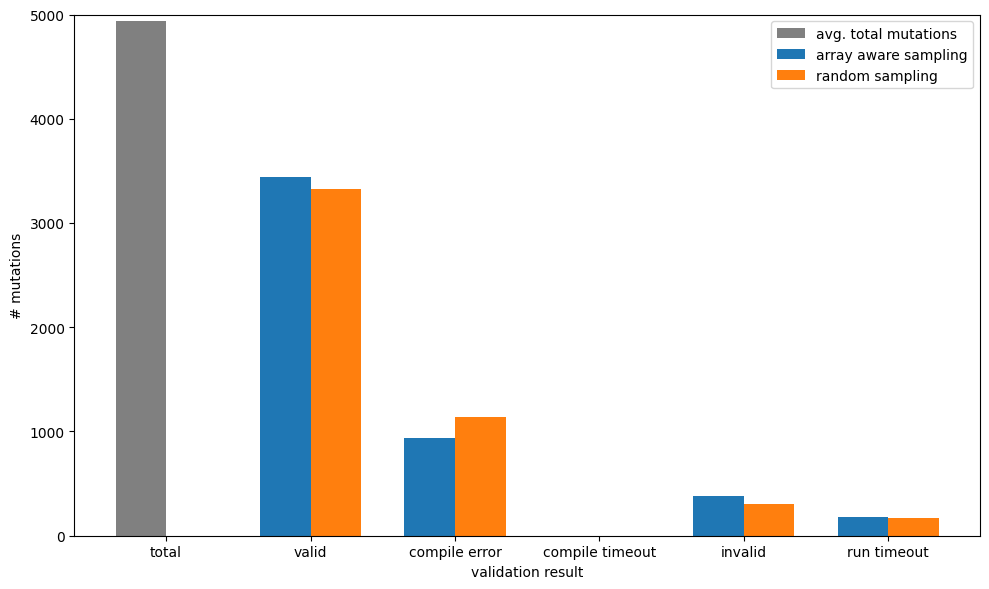

In [83]:
# Assuming your DataFrame is named 'df'
# Selecting the rows with run_name "compare-runtime-int8"
random_rows = df[df['run_name'] == 'evaluate_array_awareness-random']
aware_rows = df[df['run_name'] == 'evaluate_array_awareness-array_aware']

# Calculating the average of NUM_THREADS for each total_elapsed_s in int8_rows
random_avg_time = random_rows['total_elapsed_s'].mean()
aware_avg_time = aware_rows['total_elapsed_s'].mean()

print(f"average time random sampling: {random_avg_time}")
print(f"average time array-aware sampling: {aware_avg_time}")


# Calculating the counts of mutation types for "compare-runtime-int8"
random_avg_counts = random_rows[['mutated_valid', 'mutated_compile_error', 'mutated_compile_timeout', 'mutated_invalid', 'mutated_run_timeout']].mean()
random_avg_counts = pd.Series([np.nan]).append(random_avg_counts)

# Calculating the counts of mutation types for "compare-runtime"
aware_avg_counts = aware_rows[['mutated_valid', 'mutated_compile_error', 'mutated_compile_timeout', 'mutated_invalid', 'mutated_run_timeout']].mean()
aware_avg_counts = pd.Series([np.nan]).append(aware_avg_counts)

aware_avg_counts_avg = aware_rows['total_attempts'].mean()
random_avg_counts_avg = random_rows['total_attempts'].mean()
avg_total_mutations = pd.Series([(aware_avg_counts_avg + random_avg_counts_avg) / 2, 0, 0, 0, 0, 0])


# Getting the mutation types as columns
mutation_types = aware_avg_counts.index
mutation_types = ["total"] + [" ".join(x.split("_")[1:]) for x in mutation_types[1:]]

# Plotting the bar plot
bar_width = 0.35
index = range(len(mutation_types))
plt.figure(figsize=(10, 6))

plt.bar(index, avg_total_mutations, bar_width, color="grey", label='avg. total mutations')
plt.bar(index, aware_avg_counts, bar_width, label='array aware sampling')
plt.bar([i + bar_width for i in index], random_avg_counts, bar_width, label='random sampling')

# Adding labels and ticks
# plt.title("mutation validity sampling int8+ vs. int32+ consts")
plt.xlabel('validation result')
plt.ylabel('# mutations')
plt.xticks([i + bar_width/2 for i in index], mutation_types)
plt.ylim(0, 5000)

# Adding legend
plt.legend()
plt.tight_layout()

plt.savefig('validation_comparison_strategy.pdf')

# Display the plot
plt.show()
